In [225]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [226]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd

In [227]:
import trackml
from trackml.dataset import load_event, load_dataset

In [228]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['x1']
    y1 = h['y1']
    x2 = h['x2']
    y2 = h['y2']
    x3 = h['x3']
    y3 = h['y3']
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*1650 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [229]:
def deltaphi(a,b,ch) :
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)

In [230]:
def alignRZ(h, ptmin) :
    ri = h['r1']
    zi = h['z1']
    rm = h['r2']
    zm = h['z2']
    ro = h['r3']
    zo = h['z3']
    radius_diff = abs(rm - ro)
    distance_13_squared = radius_diff*radius_diff + (zm - zo)*(zm - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = abs(zm * (ri - ro) + zi * (ro - rm) + zo * (rm - ri)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [231]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [232]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

1000 120939 120939
8708 7106 5995 5146


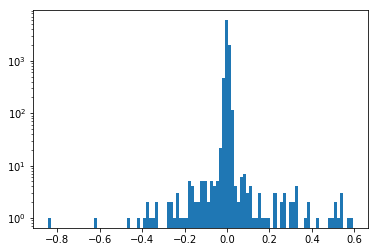

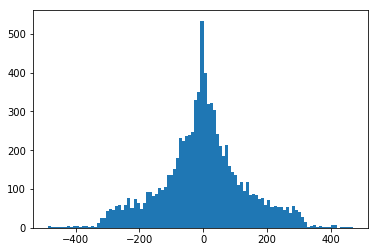

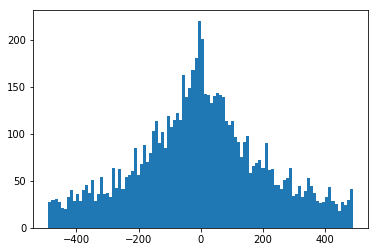

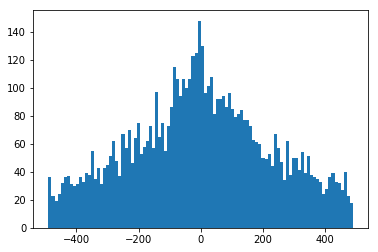

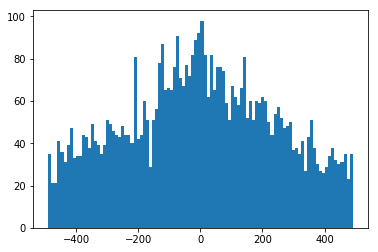

min/max
            particle_id      phi1         r1        tpt        tpz         x1  \
min    4503668346847232 -3.141523  31.439316   0.100475 -95.488899 -34.376499   
max  968307936025640960  3.141564  34.419254  55.737206  76.454498  34.355900   

            y1          z1  
min -34.382500 -485.998993  
max  34.371201  468.515015  
            particle_id      phi2         r2       tpt2       tpz2         x2  \
min    4503668346847232 -3.141205  71.066437   0.101623 -95.323196 -73.824997   
max  968306218038722560  3.140763  73.881020  56.019302  76.453697  73.873100   

            y2          z2  
min -73.787598 -490.473999  
max  73.827904  490.782013  
            particle_id      phi3          r3          x3          y3  \
min    4503668346847232 -3.140715  114.879425 -117.661003 -117.702003   
max  968306149319245824  3.136758  117.707825  117.702003  117.680000   

             z3  
min -490.528992  
max  490.691986  
            particle_id      phi4          r4          x

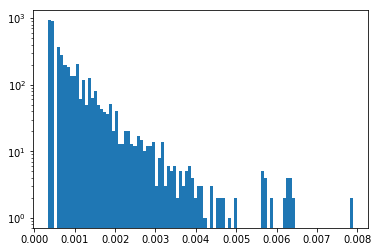

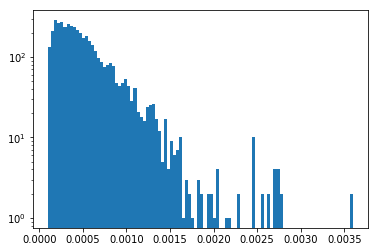

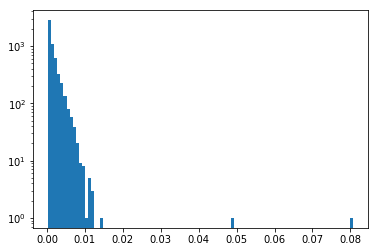

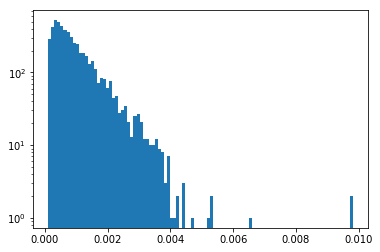

field


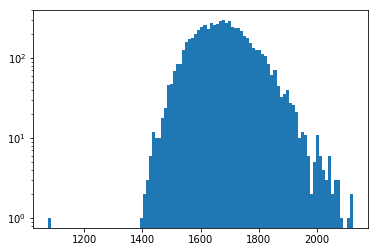

thcut 6784
8708 6155


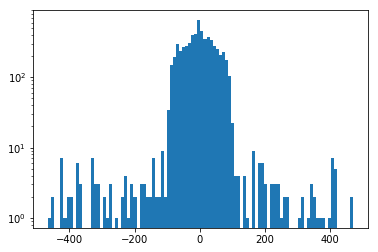

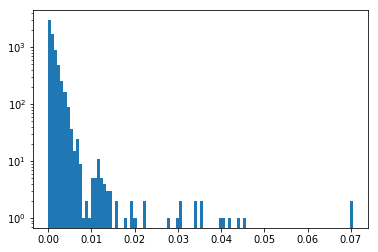

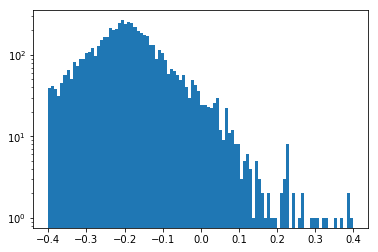

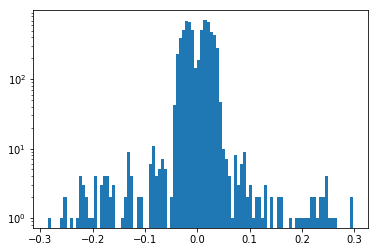

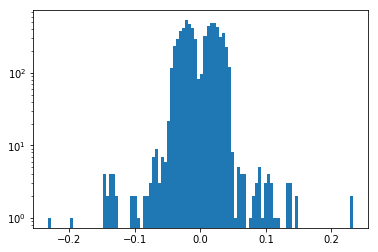

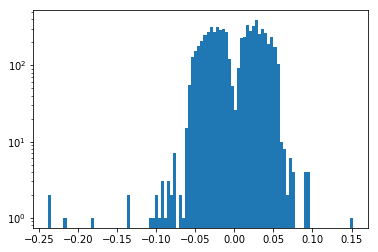

1001 93680 93680
6541 5277 4340 3612


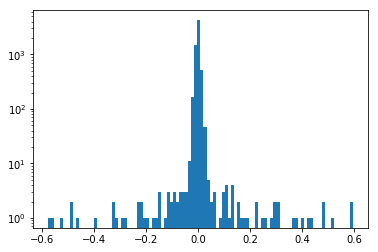

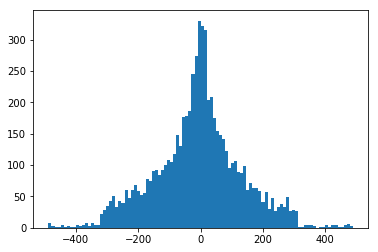

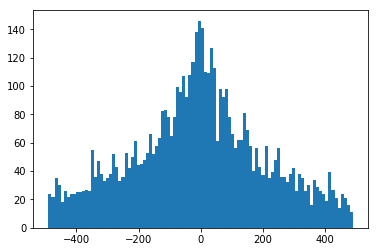

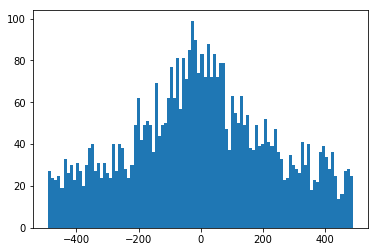

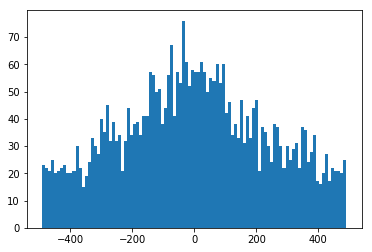

min/max
            particle_id      phi1         r1        tpt         tpz  \
min    4503668346847232 -3.141539  31.439316   0.100131 -170.863998   
max  909735645943955456  3.140824  34.425499  77.112946   64.074501   

            x1         y1          z1  
min -34.363201 -34.357101 -487.765991  
max  34.381802  34.362000  488.335999  
            particle_id      phi2         r2       tpt2        tpz2  \
min    4503668346847232 -3.141191  71.066391   0.102479 -170.863998   
max  909735645943955456  3.141340  73.881088  77.112335   64.073997   

            x2         y2          z2  
min -73.762604 -73.865700 -490.360992  
max  73.807800  73.865601  489.950989  
            particle_id      phi3          r3          x3          y3  \
min    4503668346847232 -3.137727  114.880264 -117.591003 -117.646004   
max  909735645943955456  3.138562  117.707802  117.650002  117.515999   

             z3  
min -490.677002  
max  489.723999  
            particle_id      phi4          r4     

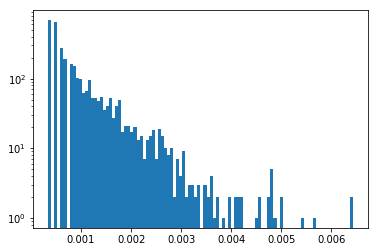

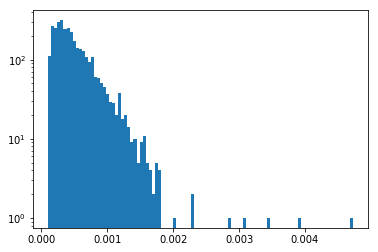

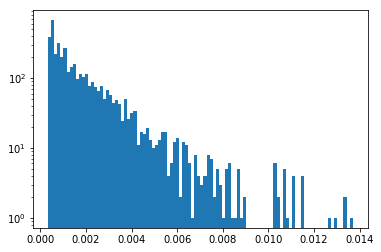

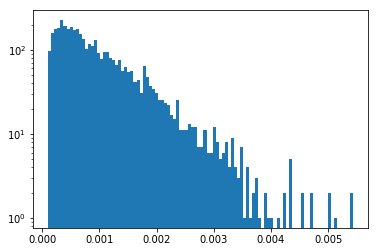

field


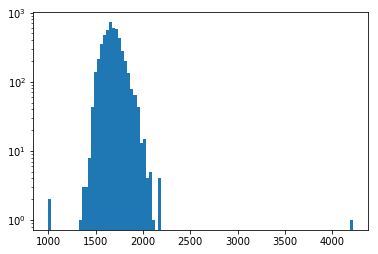

thcut 4977
6541 4398


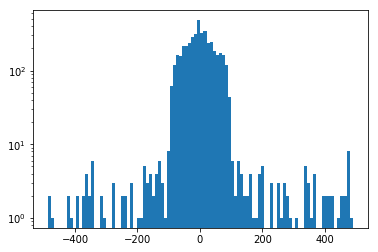

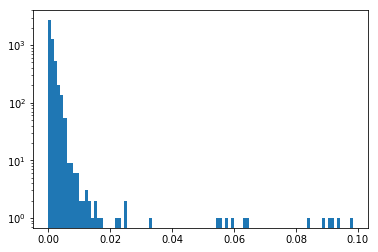

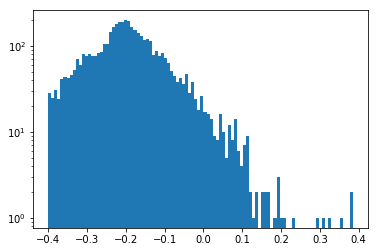

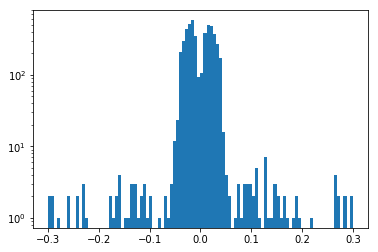

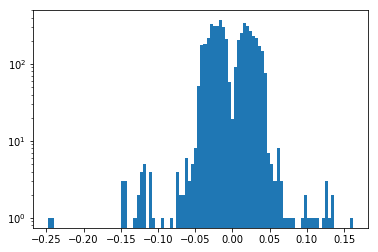

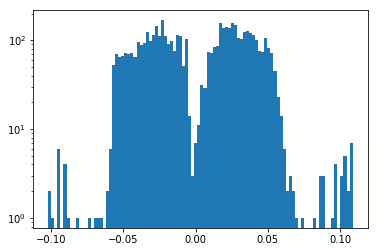

done 3


In [236]:
file = '/Users/innocent/data/trackML_minitrain.zip'
#file = '/Users/innocent/data/train_100_events'
maxEv = 2
evn=0
for event_id, hits, cells, particles, truth in load_dataset(file):
    evn+=1
    if (evn>maxEv) : break
    print event_id, len(hits), len(truth)
    #hits = pd.concat([hits,truth],axis=1)
    hits = pd.merge(hits,truth,on='hit_id')
    hits['phi'] = np.arctan2(hits['y'],hits['x'])
    hits['r'] = np.sqrt(hits['y']*hits['y']+hits['x']*hits['x'])
    hits['tr'] = np.sqrt(hits['ty']*hits['ty']+hits['tx']*hits['tx'])
    hits['tpt'] = np.sqrt(hits['tpx']*hits['tpx']+hits['tpy']*hits['tpy'])
    hits['up0'] =0
    hits['up1'] =0
    particles['pt'] = np.sqrt(particles['px']*particles['px']+particles['py']*particles['py'])

    hits.sort_values(by=['particle_id'],inplace=True)
    # print hits
    hl1 = hits.query('volume_id ==8 & layer_id==2 & particle_id!=0')
    hl2 = hits.query('volume_id ==8 & layer_id==4 & particle_id!=0')
    hl3 = hits.query('volume_id ==8 & layer_id==6 & particle_id!=0')
    hl4 = hits.query('volume_id ==8 & layer_id==8 & particle_id!=0')
    print len(hl1), len(hl2), len(hl3), len(hl4)
    plt.hist(hl1['z']-hl1['tz'],log=True, bins=100)
    plt.show()
    plt.hist(hl1['z'],log=False, bins=100)
    plt.show()
    plt.hist(hl2['z'],log=False, bins=100)
    plt.show()
    plt.hist(hl3['z'],log=False, bins=100)
    plt.show()
    plt.hist(hl4['z'],log=False, bins=100)
    plt.show()

    z0 =  pd.DataFrame({ 'pt' : particles['pt'],
                         'pz' : particles['pz'],
                        'particle_id' : particles['particle_id']
                        })
    z1 = pd.DataFrame({ 'z1' : hl1['z'],
                       'x1' : hl1['x'],
                       'y1' : hl1['y'],
                       'r1' : hl1['r'],'phi1' : hl1['phi'],
                       'tpt' : hl1['tpt'],
                       'tpz' : hl1['tpz'],
                       'particle_id' : hl1['particle_id']
                       })
    z2 = pd.DataFrame({ 'z2' : hl2['z'],
                       'x2' : hl2['x'],
                       'y2' : hl2['y'],
                       'r2' : hl2['r'],'phi2' : hl2['phi'],
                       'tpt2' : hl2['tpt'],
                       'tpz2' : hl2['tpz'],
                       'particle_id' : hl2['particle_id']
                       })
    z3 = pd.DataFrame({ 'z3' : hl3['z'],
                       'x3' : hl3['x'],
                       'y3' : hl3['y'],
                       'r3' : hl3['r'],'phi3' : hl3['phi'],
                       'particle_id' : hl3['particle_id']
                       })
    z4 = pd.DataFrame({ 'z4' : hl4['z'],
                       'x4' : hl4['x'],
                       'y4' : hl4['y'],
                       'r4' : hl4['r'],'phi4' : hl4['phi'],
                       'particle_id' : hl4['particle_id']
                       })

    print 'min/max'
    print z1.agg(['min','max'])
    print z2.agg(['min','max'])
    print z3.agg(['min','max'])
    print z4.agg(['min','max'])
    p4 = pd.DataFrame({'particle_id' :hl4['particle_id']})
    t123 = pd.merge(z0,z1,on='particle_id')
    t123 = pd.merge(t123,z2,on='particle_id')
    t123 = pd.merge(t123,z3,on='particle_id')
    t1234 = pd.merge(t123,z4,on='particle_id')
    print 't123',len(t123),len(t123[t123['tpt']>0.3])
    # print t123
    t123 = t123[t123['tpt']>0.3]
    t1234 = t1234[t1234['tpt']>0.3]
    
    print 'delta'
    dt0,dtn0 = ml(t123['pt'],t123['pz'],t123['tpt'],t123['tpz'])
    plt.hist(dt0[dt0<0.01], log=True, bins=100)
    plt.show()
    plt.hist(dtn0[dtn0<0.01], log=True, bins=100)
    plt.show()
  
    dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
    plt.hist(dt[dt<0.1], log=True, bins=100)
    plt.show()
    plt.hist(dtn[dtn<0.1], log=True, bins=100)
    plt.show()
    thcut = alignRZ(t123,0.6)
    curv = curvature(t123,0.6,0.2,0.2)
    rad = curvature(t123,0.6,0.2,0.2,True)
    field = rad/t123['tpt']
    print 'field'
    plt.hist(field[abs(field)>1000],log=True, bins=100)
    plt.show()
    print 'thcut',len(thcut)
    # print thcut
    # print curv
    zl4 = pd.merge(z1,p4,on='particle_id')
    print len(z1),len(zl4)
    # plt.hist(z1['z'],log=True, bins=100)
    plt.hist(zl4['z1'],log=True, bins=100)
    plt.show()
    plt.hist(thcut[thcut<0.1],log=True, bins=100)
    plt.show()
    plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
    plt.show()
    d1 = t123['phi1']-t123['phi2']
    plt.hist(d1[abs(d1)<0.3], bins=100,log=True)
    plt.show()
    d2 = t123['phi2']-t123['phi3']
    plt.hist(d2[abs(d2)<0.3], bins=100,log=True)
    plt.show()
    d3 = t1234['phi4']-t1234['phi3']
    plt.hist(d3[abs(d3)<0.3], bins=100,log=True)
    plt.show()
    
    
print 'done', evn